In [1]:
# creat all figures
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib.patches as mpatches
from matplotlib import rc
# import latex
rc("text", usetex=False)

Plot RMSE from cross validation

In [2]:
%load_ext autoreload
%autoreload 2
from basic.plot import plot_error_cv

plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')

In [3]:
def df_return(fp, fn):
    error_stats = pd.read_csv(f'{fp}{fn}', index_col = 'index')
    cols = error_stats.columns
    error_stats.loc[:, cols[1]] = error_stats.loc[:, cols[0]] - error_stats.loc[:, cols[1]]
    error_stats.loc[:, cols[2]] = error_stats.loc[:, cols[2]] - error_stats.loc[:, cols[0]]  
    df_temp = error_stats.iloc[:]
    
    return df_temp

In [4]:
# Plot errors of cross-validation
from matplotlib import rcParams

# filepath = ['../output/paper0915/', '../output/paper0915/figure4/test_plot/', '../output/paper0915/figure4/test1013/']
filepath = ['../output/adaptive/']
filename = ['error_cv_uniform_552.csv', 'error_cv_exact_552.csv', 'error_cv_full_552.csv']
# filename_22 = 'error_cv_full_552.csv'

# error_stats = pd.read_csv(f'{filepath[0]}{filename_22}').iloc[0]

df_uniform = df_return(filepath[0], filename[0])
df_uniform = df_uniform.filter(items=['mean'])
cols = df_uniform.columns
df_uniform.rename(columns={col: col+'_uni' for col in cols if col == 'mean'}, inplace=True)
df_22 = df_return(filepath[0], filename[2])
df_22 = df_22.filter(items=['mean'])
df_22.rename(columns={col: col+'_22' for col in cols}, inplace=True)

df_exact = df_return(filepath[0], filename[1])
df_exact = df_exact.filter(items=['mean'])
df_exact.rename(columns={col: 'mean_exact' for col in cols}, inplace=True)

df = pd.concat([df_uniform, df_exact, df_22], axis=1)
# df.loc['nsample_552', 'mean_22_uni'] = error_stats['mean']

df_cols = df.columns
keys = ['legend', 'legend_low', 'legend_up']
legend_dict = {}
for ind in range(len(keys)):
    legend_dict[keys[ind]] = [df_cols[i] for i in range(len(df_cols)) if (i % 3) ==ind]

df = df.reset_index()
# plt.savefig(f'{filepath}/figure/pce_compare.png', format='png', dpi=300)

In [5]:
train_vals = pd.read_csv(filepath[0]+'samples_adjust.csv').values[:, -1]
xticks = np.array([int(i.split('_')[1]) for i in df['index'].values])
std_list = [train_vals[0:n].std() for n in xticks]

In [6]:
# std_train_samples = int(4307583)
# calculate the relative RMSE which is the RMSE normalized by the standard deviation
df = df.fillna(0)
for col in df.columns[1:]:
    df.loc[:, col] = df.loc[:, col] / std_list
# df.loc[:, df.columns[1:]] = df.loc[:, df.columns[1:]].apply()
df = df.replace(0,np.nan)
df.head()

,index,mean_uni,mean_exact,mean_22
0,nsample_10,0.662581,0.662581,NaN
1,nsample_20,1.618543,0.023639,0.987574
2,nsample_30,0.081533,1.180051,0.088416
3,nsample_40,0.088851,1.411771,1.609760
4,nsample_50,3.459483,0.025352,0.172487


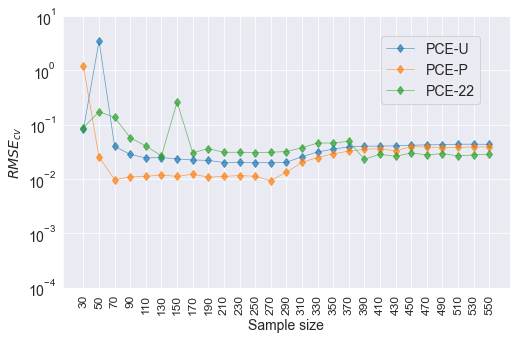

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(8, 5))
index_plot = np.array(np.arange(2, 56, 2))
xticks = [int(i.split('_')[1]) for i in df['index'].values[index_plot]]
ax1 = df.iloc[index_plot].plot(x='index', y=df.columns[1:], kind='line', marker='d',
                legend=True, logy=True, xticks=np.arange(len(xticks)), ax=axes, linewidth=0.7, alpha=0.7)

rcParams['ytick.labelsize'] = 14
ax1.legend(['PCE-U', 'PCE-P', 'PCE-22'], bbox_to_anchor=(0.95, 0.95), fontsize=14)
ax1.set_ylabel(r'$RMSE_{cv}$', fontsize = 14);
ax1.set_xlabel('Sample size', fontsize = 14);
ax1.set_ylim(1e-4, 1e1)
ax1.set_xticklabels(xticks, rotation=90, fontsize=12)

# ax2.set_xticklabels(labels = [143, 156, 234, 312, 390, 552], fontsize = 14, rotation=90);
rcParams['ytick.labelsize'] = 14
plt.savefig(f'{filepath[0]}figure/Figure4.png', format='png', dpi=300)

## Bar plot of sensitivity indices

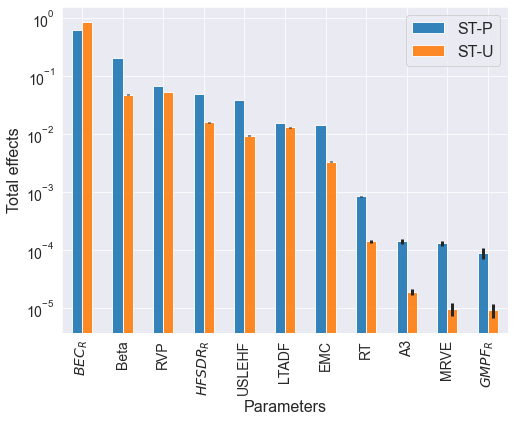

In [57]:
# plot sensitivity for PCE with 11 parameters of Beta, Uniform dists
filepath = '../output/adaptive/'
df_plot = pd.read_csv(f'{filepath}sa_fig.csv', index_col= 'Unnamed: 0')
cols = df_plot.columns
legend = ['ST', 'ST_Uniform']
legend_low = [lab+'_lower' for lab in legend]
legend_up = [lab+'_upper' for lab in legend]
for lab in legend:
    df_plot.loc[:, f'{lab}_lower'] = df_plot.loc[:, lab] - df_plot.loc[:, f'{lab}_lower'] 
    df_plot.loc[:, f'{lab}_upper'] = df_plot.loc[:, f'{lab}_upper'] - df_plot.loc[:, lab]

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y=legend, kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, [*legend_low, *legend_up]].T.values, 
                legend=True, logy=True, xticks=np.arange(df_plot.shape[0]), alpha=0.9)
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16); 
xticks = df_plot.short_name.values
xticks[0] = r'$BEC_R$'; xticks[3] = r'$HFSDR_R$'; xticks[-1] = r'$GMPF_R$'
ax.set_xticklabels(df_plot.short_name.values, rotation=90, fontsize=14);
ax.legend(['ST-P', 'ST-U'])
plt.savefig(f'{filepath}figure/Figure5-log-bar.png', format='png', dpi=300, bbox_inches='tight') 

## Plot Figure 7

In [23]:
# calculate the changes in the confidence intervals
# heat map 
# filepath = '../output/paper0915/error_measures/1029_cal/'
product_uniform = 'exact'
filepath = f'../output/adaptive/{product_uniform}/'
filename = ['cf_width', 'cf_width_lower', 'cf_width_upper']
df_mean = pd.read_csv(f'{filepath}{filename[0]}.csv', index_col = 'Unnamed: 0')
df_lower = pd.read_csv(f'{filepath}{filename[1]}.csv', index_col = 'Unnamed: 0')
df_upper = pd.read_csv(f'{filepath}{filename[2]}.csv', index_col = 'Unnamed: 0')
df_lower = 1 - df_lower
cols = df_mean.columns
for col in cols:
    ind = df_mean[df_mean[col]>1].index.tolist()
    if len(ind) > 0: df_lower.loc[ind, col] = 1 - df_upper.loc[ind, col]
# df_lower.to_csv(f'{filepath}cf_changes.csv', index=True)

Line plot for three error measures

In [24]:
# prepare the data for plot: confidence intervals and the coefficient of variation
# filepath = '../output/paper0915/error_measures/1029_cal/'
filepath = f'../output/adaptive/{product_uniform}/'
path_save = '../output/adaptive/figure'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']

# get data in the corresponding column
num_params = 11
col_filter = ['nsample_90']
df = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params]
for f in filename:
    df[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df.index = np.arange(df.shape[0], 0, -1)
df.index.name = 'Num of parameters fixed'
df.reset_index(inplace=True)
# add the one with no parameter fixed

In [25]:
# df.drop_duplicates(subset='cv', keep='first', inplace=True)
# import unconditional stats
with open(f'{filepath}y_uncond_stats.json', 'r') as fp:
    uncond_stats = json.load(fp)
uncond_stats =  uncond_stats['nsample_90']
df.loc[11, 'Num of parameters fixed'] = 0
df.loc[11, 'cf_upper'] = uncond_stats['uncond_cf_up']['mean']
df.loc[11, 'cf_lower'] = uncond_stats['uncond_cf_low']['mean']
df.loc[11, 'cv'] = uncond_stats['cv']
df.loc[11, 'ks'] = 0
df.loc[11, 'pvalue'] = 1
df.loc[11, 'cf_upper_upper'] = uncond_stats['uncond_cf_up']['up']
df.loc[11, 'cf_upper_lower'] = uncond_stats['uncond_cf_up']['low']
df.loc[11, 'cf_lower_upper'] = uncond_stats['uncond_cf_low']['up']
df.loc[11, 'cf_lower_lower'] = uncond_stats['uncond_cf_low']['low']
df.loc[11, 'cond_mean'] = uncond_stats['uncond_mean']

In [26]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 1.96 * df['cv']

# drop duplicates
df.drop_duplicates(subset='cv', keep='first', inplace = True)

In [29]:
df

,Num of parameters fixed,cf_upper,cf_lower,cv,ks,pvalue,cf_upper_upper,cf_upper_lower,cf_lower_upper,cf_lower_lower,...,upper_mean,upper_mean_lower,upper_mean_upper,lower_mean,lower_mean_lower,lower_mean_upper,cf_median_mean,cf_median_lower,cf_median_upper,cf_cv
0,11.0,2.777087e+07,2.777087e+07,0.000000,0.569697,8.862807e-128,2.777299e+07,2.776530e+07,2.777299e+07,2.776530e+07,...,0.000269,0.000068,0.000345,-0.000269,-0.000068,-0.000345,0.000000,0.000201,-0.000076,0.000000
1,10.0,3.527327e+07,2.250144e+07,0.079134,0.128914,2.269621e-06,3.587164e+07,3.455793e+07,2.272782e+07,2.231557e+07,...,0.269403,0.243660,0.290937,0.190225,0.196914,0.182079,0.221063,0.227497,0.213226,0.155102
2,9.0,3.556730e+07,2.032067e+07,0.116440,0.047849,2.308901e-01,3.671421e+07,3.469004e+07,2.084296e+07,1.991932e+07,...,0.302078,0.269963,0.344065,0.256083,0.270776,0.236963,0.272807,0.287170,0.254116,0.228223
3,8.0,3.615866e+07,2.019456e+07,0.133536,0.037960,4.864456e-01,3.665069e+07,3.569339e+07,2.062874e+07,1.987532e+07,...,0.322534,0.305516,0.340530,0.261367,0.273043,0.245486,0.283286,0.294616,0.267877,0.261731
4,7.0,3.602097e+07,1.999177e+07,0.139139,0.032313,6.723481e-01,3.659489e+07,3.539256e+07,2.046376e+07,1.949004e+07,...,0.317220,0.294240,0.338207,0.268938,0.287286,0.251678,0.286170,0.304085,0.269317,0.272713
5,6.0,3.595580e+07,1.983395e+07,0.145188,0.028776,7.861334e-01,3.713555e+07,3.543235e+07,2.029497e+07,1.938214e+07,...,0.313808,0.294682,0.356916,0.275277,0.291786,0.258431,0.288975,0.305172,0.272448,0.284569
6,5.0,3.623039e+07,1.981940e+07,0.151102,0.024198,9.116441e-01,3.675747e+07,3.566997e+07,2.024012e+07,1.946987e+07,...,0.324016,0.303536,0.343278,0.275713,0.288486,0.260338,0.292793,0.305265,0.277781,0.296160
7,4.0,3.632840e+07,1.982563e+07,0.157762,0.014524,9.991600e-01,3.685858e+07,3.592607e+07,2.029924e+07,1.915582e+07,...,0.327638,0.312935,0.347014,0.275463,0.299941,0.258155,0.293884,0.317740,0.277016,0.309213
8,3.0,3.629906e+07,1.974852e+07,0.157664,0.011231,9.999728e-01,3.672174e+07,3.583324e+07,2.014664e+07,1.915847e+07,...,0.327672,0.310633,0.343132,0.277680,0.299261,0.263118,0.295294,0.316350,0.281088,0.309022
10,1.0,3.630680e+07,1.972193e+07,0.155961,0.009675,9.999970e-01,3.673263e+07,3.582582e+07,2.007732e+07,1.919548e+07,...,0.327953,0.310361,0.343528,0.278653,0.297908,0.265654,0.296007,0.314799,0.283321,0.305683


C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


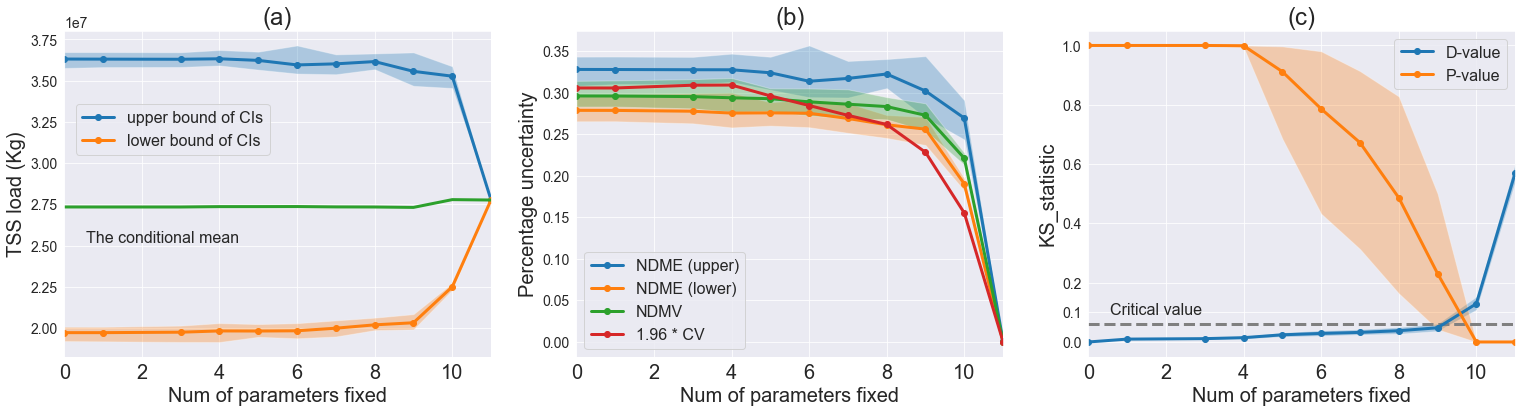

In [28]:
# Line plot
plt.rcParams["text.usetex"] = False
sns.set_style('darkgrid')
fs = 16
fig, axes = plt.subplots(1, 3, sharex=True)
x_col = 'Num of parameters fixed'
ax = df.plot(x=x_col, y=filename[0:2], 
            figsize=(26, 6), marker='o', ax=axes[0])
ax.fill_between(df.loc[:, x_col], df.cf_upper_lower, df.cf_upper_upper, alpha=0.3)
ax.fill_between(df.loc[:, x_col], df.cf_lower_lower, df.cf_lower_upper, alpha=0.3)            
             
ax.plot(df.loc[:, x_col], df.cond_mean)          
ax.text(0.05, 0.35, 'The conditional mean', transform=ax.transAxes, fontsize=fs) #c='k',

ax.set_ylabel('TSS load (Kg)')
ax.legend(['upper bound of CIs', 'lower bound of CIs'], fontsize=fs, bbox_to_anchor=(0.5, 0.8))
ax.set_title("(a)", loc='center', fontsize=24)

ax1 = df.plot(x_col, ['upper_mean', 'lower_mean', 'cf_median_mean', 'cf_cv'], marker='o', ax=axes[1])
ax1.fill_between(df.loc[:, x_col], df.upper_mean_lower, df.upper_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.lower_mean_lower, df.lower_mean_upper, alpha=0.3)
ax1.fill_between(df.loc[:, x_col], df.cf_median_lower, df.cf_median_upper, alpha=0.3)
ax1.set_ylabel('Percentage uncertainty') 
ax1.legend(['NDME (upper)', 'NDME (lower)', 'NDMV', '1.96 * CV'], fontsize=fs)
ax1.set_title("(b)", loc='center', fontsize=24);

ax2 = df.plot(x_col,['ks', 'pvalue'], marker='o', ax=axes[2])
ax2.fill_between(df.loc[:, x_col], df.ks_lower, df.ks_upper, alpha=0.3)
ax2.fill_between(df.loc[:, x_col], df.pvalue_lower, df.pvalue_upper, alpha=0.3)
ax2.hlines(0.061, xmin=0, xmax=11, linestyle = '--', color='grey')          
ax2.text(0.05, 0.13, 'Critical value', transform=ax2.transAxes, fontsize=fs) #c='k',
ax2.set_xlim(*x_range)
ax2.set_yticks([0, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('KS_statistic')
ax2.legend(['D-value', 'P-value'], fontsize=fs) ;
ax2.set_xlabel(x_col);
ax2.set_title("(c)", loc='center', fontsize=24);
plt.savefig(f'{path_save}/{product_uniform}_figure7_uncertainty_communication.png', format='png', dpi=300, bbox_inches='tight')

## Figure 8 Line plot for showing robustness of error estimation

In [34]:
# Adaptive evaluation of error measure
# filepath = '../output/paper0915/error_measures/1029_cal/'
product_uniform = 'exact'
filepath = f'../output/adaptive/{product_uniform}/'
path_save = '../output/adaptive/figure'
filename = ['cf_lower_adaptive', 'cf_lower_lower_adaptive', 'cf_lower_upper_adaptive',
            'cf_upper_adaptive', 'cf_upper_lower_adaptive', 'cf_upper_upper_adaptive', 'cond_mean_adaptive']# 'stats_uncond_adaptive'

In [35]:
# sort the dataframe for plot
df = pd.DataFrame()
for fn in filename[:]:
    print(fn)
    df[fn] = pd.read_csv(f'{filepath}{fn}.csv', index_col = 'Unnamed: 0').iloc[2]
# df.loc[:, 'median'] = (df.loc[:, filename[0]] + df.loc[:, filename[3]]) / 2 # only use the mean of CIs for calculation

cf_lower_adaptive
cf_lower_lower_adaptive
cf_lower_upper_adaptive
cf_upper_adaptive
cf_upper_lower_adaptive
cf_upper_upper_adaptive
cond_mean_adaptive


In [36]:
df_ratio = pd.DataFrame(index=df.index, columns=df.columns)
for fn in filename[:-1]:
    if 'cf_lower' in fn:
        df_ratio.loc[:, fn] = (df.loc[:, cols[-1]] - df.loc[:, fn]) / df.loc[:, cols[-1]]
    else:
        df_ratio.loc[:, fn] = (df.loc[:, fn] - df.loc[:, cols[-1]]) / df.loc[:, cols[-1]]
df_ratio.loc[:, cols[-1]] = df.loc[:,cols[-1]]

C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
C:\Users\qianw\anaconda3\envs\ffexplore\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
<ipython-input-43-49e341a3a4a9>:31: MatplotlibDeprecationWarning: savefig

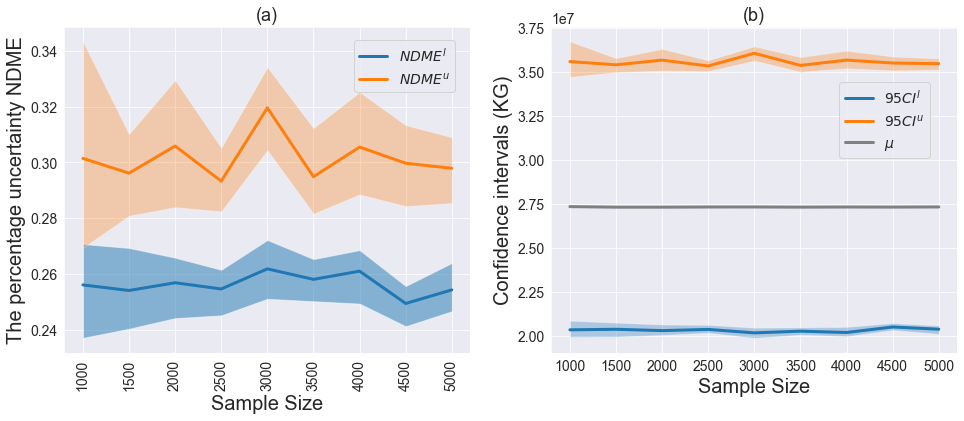

In [43]:

plt.rcParams.update({'font.size': 8})
fs=14
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2)
ind = list(df.index)
df = df.loc[ind[0:9], :]
ind = list(df.index)

ax1 = df_ratio.loc[ind, cols[[0, 3]]].plot(ax=axes[0])
plt.sca(axes[1])
plt.xticks(range(len(df.index)), df_ratio.index[0:9], rotation=90)
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.fill_between(df.index, df_ratio.loc[ind,cols[1]], df_ratio.loc[ind, cols[2]], alpha=0.5)
ax1.fill_between(df.index, df_ratio.loc[ind, cols[4]], df_ratio.loc[ind, cols[5]], alpha=0.3)
ax1.set_xlabel('Sample Size');
ax1.set_ylabel('The percentage uncertainty NDME');
ax1.legend([f'$NDME^l$', f'$NDME^u$'], bbox_to_anchor=[0.98, 0.98], fontsize=fs);
ax1.set_title('(a)', loc='center', fontsize=18)

ax = df[cols[[0, 3]]].plot(figsize=(16, 6), ax=axes[1])
plt.sca(axes[0])
df[cols[-1]].plot(ax=ax, color='grey')
plt.xticks(range(len(df.index)), df.index, rotation=90)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.fill_between(df.index, df[cols[1]], df[cols[2]], alpha=0.3)
ax.fill_between(df.index, df[cols[4]], df[cols[5]], alpha=0.3)
ax.set_xlabel('Sample Size');
ax.set_ylabel('Confidence intervals (KG)');
ax.legend([f'$95CI^l$', f'$95CI^u$', r'$\mu$'], bbox_to_anchor=[0.95, 0.85], fontsize=fs)
ax.set_title('(b)', loc='center', fontsize=18);
plt.savefig(f'{path_save}/{product_uniform}_conf_adaptive_two_panels_5000.png', format='png', dpi=300, layout='tight')

## Compare results from different factor fixing practice

In [3]:
# prepare the data for plot: confidence intervals and the coefficient of variation
filepath = '../output/paper0915/error_measures/1029_cal/'
filename = ['cf_upper', 'cf_lower', 'cv', 'ks', 'pvalue', 'cf_upper_upper', 
'cf_upper_lower', 'cf_lower_upper', 'cf_lower_lower',
'ks_lower', 'ks_upper', 'pvalue_lower', 'pvalue_upper', 'cond_mean']
# get data in the corresponding column
num_params = 11
col_filter = ['nsample_156']
df_framework = pd.DataFrame(index=np.arange(num_params), columns=filename)
x_range = [0, num_params]
for f in filename:
    df_framework[f] = pd.read_csv(f'{filepath}{f}.csv').loc[:, col_filter]
df_framework.index = np.arange(df_framework.shape[0], 0, -1)
df_framework.index.name = 'Num of parameters fixed'
df_framework.reset_index(inplace=True)
# add the one with no parameter fixed

In [4]:
filepath = '../output/paper0915/'
files = ['fix_threshold.csv', 'fix_threshold_10percent.csv'] #'fix_dummy.csv','fix_beta_dummy.csv', 
df_plot = pd.read_csv(filepath+files[0], index_col = 'Unnamed: 0').T
df_plot.rename(columns = {0: 'threshold (0.01)'}, inplace=True)
df_plot.loc[:, 'threshold (0.1)'] = pd.read_csv(filepath+files[1], index_col = 'Unnamed: 0').T
# df_plot.loc[:, 'beta_dummy'] = pd.read_csv(filepath+files[2], index_col = 'Unnamed: 0').T
# df_plot.loc[:, 'beta_threshold'] = pd.read_csv(filepath+files[3], index_col = 'Unnamed: 0').T
# load uncond file
with open(f'{filepath}error_measures/1029_cal/y_uncond_stats.json', 'r') as fp:
    uncond = json.load(fp)
df_plot.loc['cf_upper', 'uncond'] = uncond['nsample_156']['uncond_cf_up']['mean']
df_plot.loc['cf_upper_upper', 'uncond'] = uncond['nsample_156']['uncond_cf_up']['up']
df_plot.loc['cf_upper_lower', 'uncond'] = uncond['nsample_156']['uncond_cf_up']['low']
df_plot.loc['cf_lower', 'uncond'] = uncond['nsample_156']['uncond_cf_low']['mean']
df_plot.loc['cf_lower_upper', 'uncond'] = uncond['nsample_156']['uncond_cf_low']['up']
df_plot.loc['cf_lower_lower', 'uncond'] = uncond['nsample_156']['uncond_cf_low']['low']
df_plot.loc['cond_mean', 'uncond'] = uncond['nsample_156']['uncond_mean']
df_plot.loc['cv', 'uncond'] = uncond['nsample_156']['cv']
df_plot.loc[['ks', 'ks_upper', 'ks_lower'], 'uncond'] = 0
df_plot.loc[['pvalue', 'pvalue_upper', 'pvalue_lower'], 'uncond'] = 1


In [5]:
# combine df_plot and results of fixing 9 factors by using the framework
df_framework = pd.DataFrame(df_framework.iloc[2].T)
df_framework.rename(columns={2: 'Framework'}, inplace=True)
df = pd.concat([df_plot, df_framework], axis=1)
df.dropna(axis=0, inplace=True)

# change the order of columns so that the unconditional value is in the first column
cols = df.columns
columnsTitles = [cols[2], *cols[0:2], cols[-1]]
df = df.reindex(columns=columnsTitles)
df = df.T

In [6]:
# add the relative change of CIs formed as the deviation to median
cf_median = (df.loc[:, 'cf_upper'] + df.loc[:, 'cf_lower']) / 2
df.loc[:, 'upper_mean'] = (df.cf_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_lower'] = (df.cf_upper_lower - df.cond_mean) / df.cond_mean
df.loc[:, 'upper_mean_upper'] = (df.cf_upper_upper - df.cond_mean) / df.cond_mean
df.loc[:, 'lower_mean'] = (df.cond_mean - df.cf_lower) / df.cond_mean
df.loc[:, 'lower_mean_lower'] = (df.cond_mean - df.cf_lower_lower) / df.cond_mean
df.loc[:, 'lower_mean_upper'] = (df.cond_mean - df.cf_lower_upper) / df.cond_mean
df.loc[:, 'cf_median_mean'] = (cf_median - df.cf_lower) / cf_median
df.loc[:, 'cf_median_lower'] = (cf_median - df.cf_lower_lower) / cf_median
df.loc[:, 'cf_median_upper'] = (cf_median - df.cf_lower_upper) / cf_median
df.loc[:, 'cf_cv'] = 1.96 * df['cv']
df.reset_index(inplace=True)

In [7]:
for j in range(len(metrics[:-2]), len(metrics)):
    print(j)

NameError: name 'metrics' is not defined

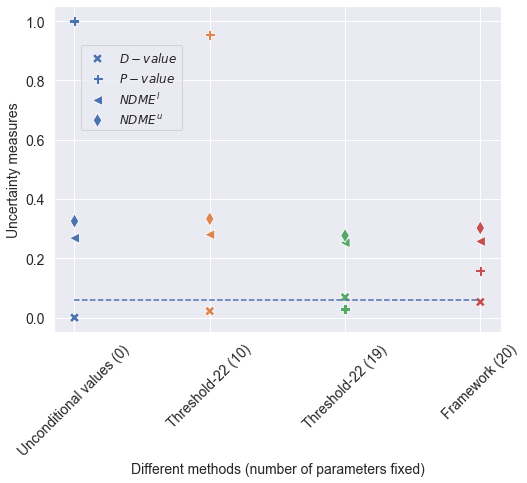

In [13]:
sns.set()
fig, ax = plt.subplots(figsize=[8,6])
sns.set_style('darkgrid')
markers = ['X','P', '<', 'd', 'o', 'H']
metrics = ['ks', 'pvalue', 'lower_mean', 'upper_mean', ] #'cf_cv', 'cf_upper', 'cf_lower'
ldg = [r'$D-value$', r'$P-value$', r'$NDME^l$', r'$NDME^u$'] #, '1.96*CV'
for i in range(len(metrics)):
    col = metrics[i]
    sns.scatterplot(ax=ax, x="index", y=col, hue="index", data=df, s = 100, marker=markers[i], legend=False);
# ax2 = ax.twinx()
# for j in range(len(metrics[:-2]), len(metrics)):
#     print(j)
#     col = metrics[j]
#     sns.scatterplot(ax=ax2, x="index", y=col, hue="index", data=df, s = 100, marker=markers[j], legend=False);
ax.hlines(0.061, xmin=ax.get_xticks()[0], xmax=ax.get_xticks()[-1], linestyle = '--')           
plt.legend(markers, labels=ldg, fontsize=12, bbox_to_anchor = (0.3, 0.90))
ax.set_xticklabels(['Unconditional values (0)', 'Threshold-22 (10)', 'Threshold-22 (19)', 'Framework (20)'], size=14, rotation=45) #'Threshold-11', 
ax.set_yticklabels(np.round(ax.get_yticks(), 2), size=14)
ax.set_xlabel('Different methods (number of parameters fixed)', size=14)
ax.set_ylabel('Uncertainty measures', size=14);
plt.savefig('../output/paper0915/figure/Figure10_comp_practices.png', format='png', dpi=300, bbox_inches='tight')

# Create polar scale figures
# organize the dataframe to plot


In [7]:
import itertools
statistic_show = ['cf_upper', 'cf_lower', 'ks', 'pvalue', 'upper_mean', 'lower_mean']
df_stack = []
for ii in statistic_show:
    cols = ['index', *[ii, ii + '_upper', ii + '_lower']]
    try:
        df_stack = np.vstack([df_stack, df.loc[:, cols].values])
    except ValueError:
        df_stack = df.loc[:, cols].values

In [8]:
df_polar = pd.DataFrame(data = df_stack, columns=['method', 'mean', 'upper', 'lower'])
df_polar.loc[:, 'angle'] = np.arange(0, 360, 15) * 2 * np.pi / 360
df_polar = df_polar.set_index('angle', drop=True)
df_polar.loc[:, 'type'] = list(itertools.chain(*[([ii] * 4) for ii in statistic_show]))
colors = ['blue', 'orange', 'olive', 'cyan']
df_polar.loc[:, 'colors']  = colors * 6

In [9]:
palette = sns.husl_palette(4)
colors = [palette[i] for i in range(4)]
df_polar.loc[:, 'colors']  = colors * 6

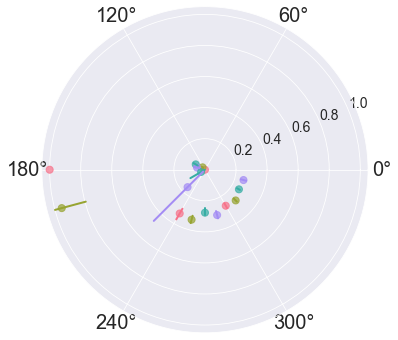

In [32]:
ticks = np.linspace(0, 2 * np.pi, 7)
sns.color_palette('colorblind')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='polar')
# ax.set_xticklabels(ax.get_xticks(), size = 14)
ax.set_xticks(ticks[0:-1])
ax.set_yticklabels(np.round(ax.get_yticks(), 1), size = 14)
c = ax.scatter(df_polar.index[8:], df_polar.iloc[8:]['mean'], c=df_polar.iloc[8:]['colors'],cmap='hsv', alpha=0.7, s=50) # s=area, 
for ii in range(8, df_polar.shape[0]):
    ax.plot([df_polar.index[ii],df_polar.index[ii]], [df_polar.iloc[ii]['lower'], df_polar.iloc[ii]['upper']], color=df_polar.iloc[ii]['colors'], linewidth=2)

# Plot the sensitivity of 22 parameters 

In [19]:
from visual_data_analysis import short_name

In [25]:
sa_22.rename(columns={'Unnamed: 0': 'Parameters'})

,Parameters,ST,ST_conf_lower,ST_conf_upper,short_name
0,BankFullFlow,0.155870,0.148509,0.163951,None
1,bankErosionCoeff,0.380634,0.368577,0.391412,None
2,BankHeight_M,0.036869,0.032105,0.041488,None
3,bankMgtFactor,0.017297,0.014335,0.020282,None
4,eventMeanConcentration,0.015973,0.013697,0.018839,None
5,HillSlopeFinePerc,0.001293,0.000699,0.002207,None
6,HillslopeFineSDR,0.047803,0.042876,0.052979,None
7,Load_Conversion_Factor,0.001532,0.000769,0.002692,None
8,RiparianVegPercent,0.065363,0.060482,0.070553,None
9,sedBulkDensity,0.004994,0.003489,0.006689,None


In [36]:
filepath = '../output/paper0915/'
filename = 'sa_pce_raw.csv'
sa_22 = pd.read_csv(filepath + filename)
sa_22.rename(columns={'Unnamed: 0': 'Parameters'}, inplace=True)
df_plot = short_name(sa_22)

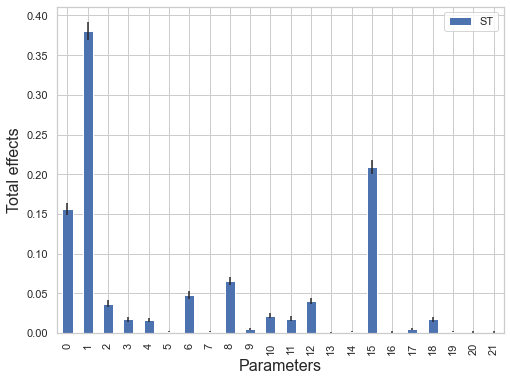

In [37]:
df_plot.loc[:, 'ST_conf_lower'] = df_plot.loc[:, 'ST'] - df_plot.loc[:, f'ST_conf_lower'] 
df_plot.loc[:, 'ST_conf_upper'] = df_plot.loc[:, 'ST_conf_upper'] - df_plot.loc[:, 'ST']

sns.set_style('whitegrid')
ax = df_plot.plot(x='short_name', y='ST', kind='bar', figsize=(8,6),
                yerr=df_plot.loc[:, ['ST_conf_lower', 'ST_conf_upper']].T.values, 
                legend=True, logy=False, xticks=np.arange(df_plot.shape[0]))
ax.set_ylabel('Total effects', fontsize=16);
ax.set_xlabel('Parameters', fontsize=16);
plt.savefig(f'{filepath}figure/total_effects_22.png', dpi=300, format='png')